In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [10]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        # Implement this!
        action_values = Q[observation]
        policy = np.eye(len(action_values))[np.argmax(action_values)]
        return policy
        
    return policy_fn

In [15]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for _ in range(num_episodes):
        episode = []
        next_observation = env.reset()
        while True:
            observation = next_observation
            action_prob = behavior_policy(observation)
            action = np.random.choice(np.arange(env.action_space.n), 
                                      p=action_prob)
            next_observation, next_reward, done, _ = env.step(action)
            episode.append([observation, action, next_reward])
            if done:
                break
        
        G = 0
        W = 1
        for j in range(len(episode)-1,-1,-1):
            observation, action, next_reward = episode[j]
            G = next_reward + discount_factor * G
            C[observation][action] += W
            Q[observation][action] = Q[observation][action] + W / C[observation][action] * (G - Q[observation][action])
            W *= target_policy(observation)[action] / behavior_policy(observation)[action]
            if W == 0:
                break
        
        target_policy = create_greedy_policy(Q)
        
    return Q, target_policy

In [16]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

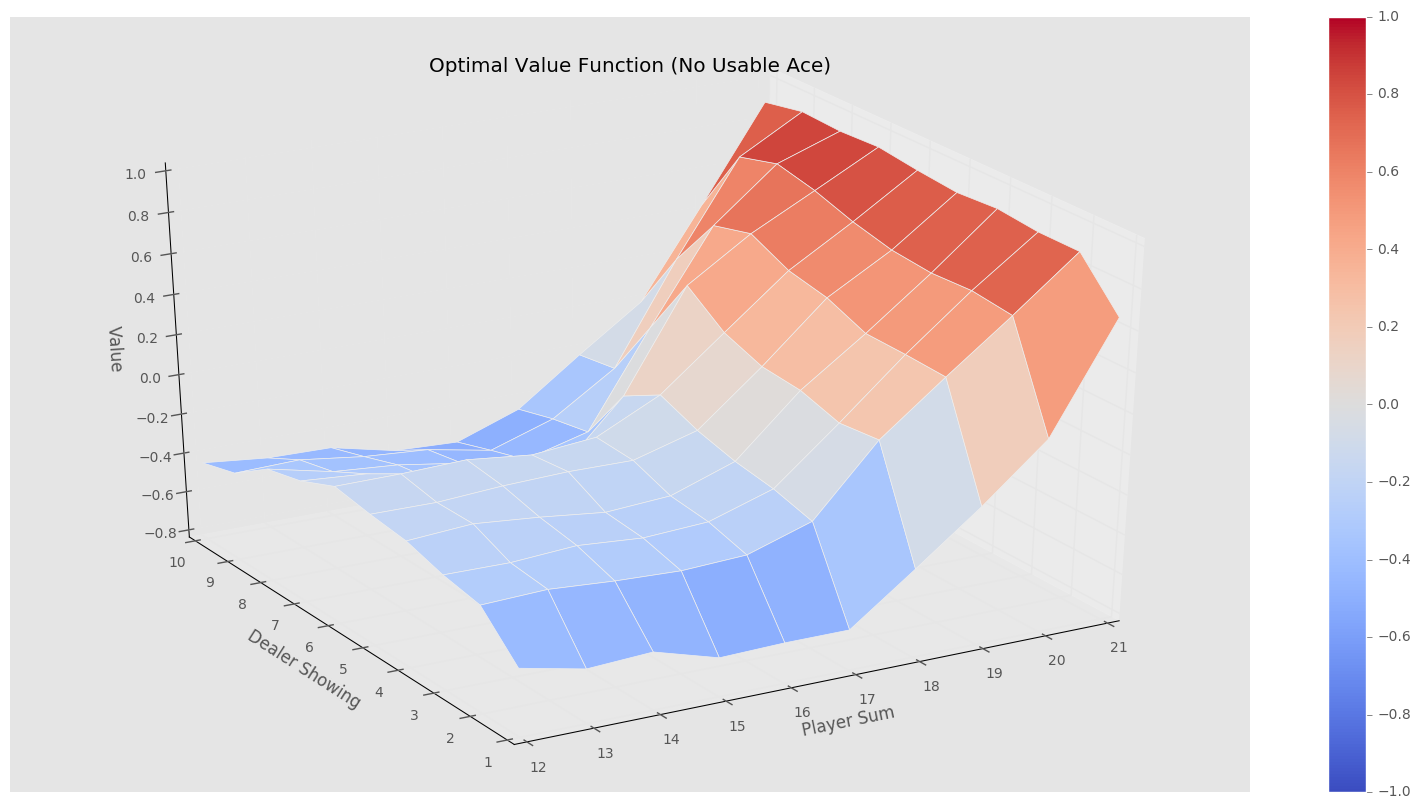

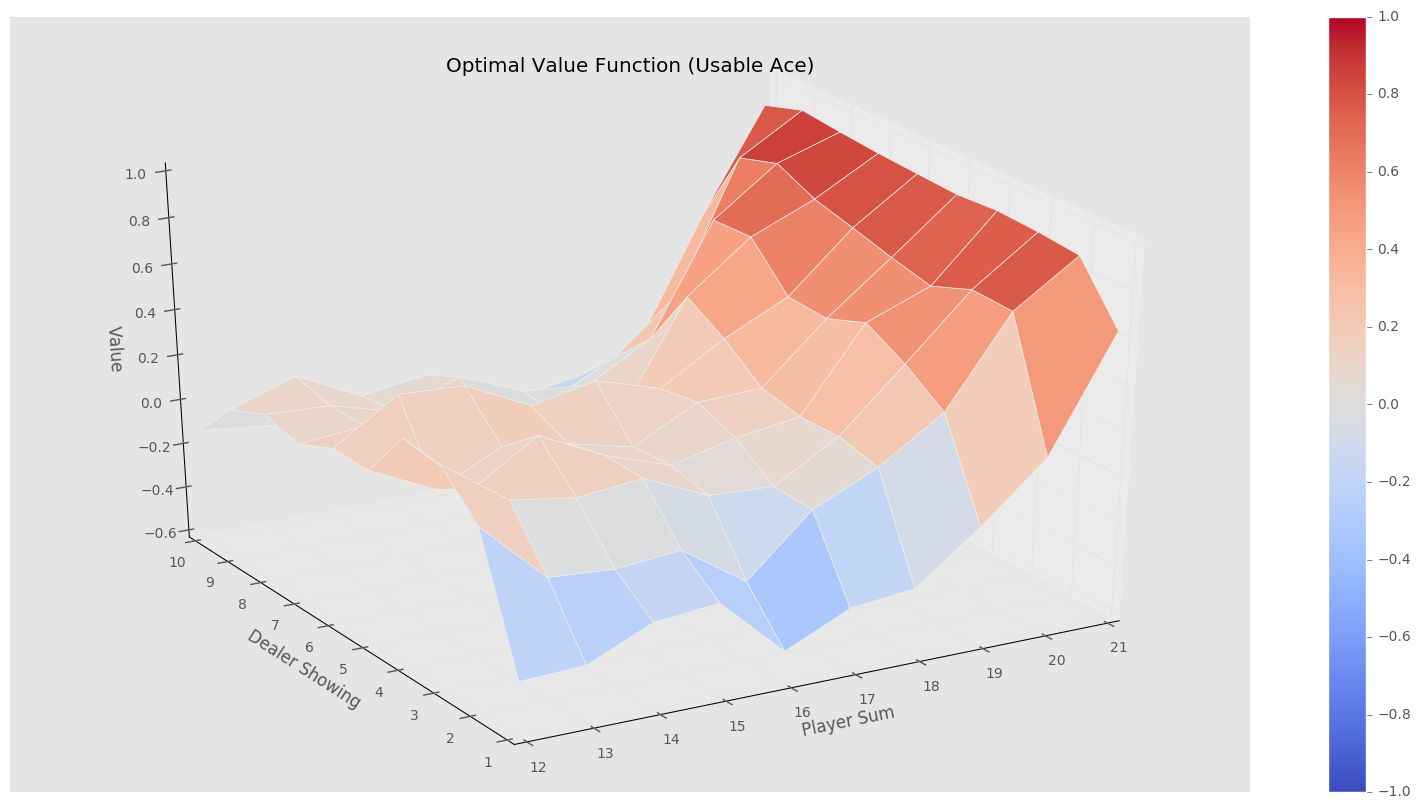

In [17]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")